In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

## Discrete Data + Probability

#### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

### Acquire

**Anomaly Detection:** Identification of items, events or observations which is significantly different from the remaining data.

- Non-parametric approach
- Frequency or counting based
    - How many time a value of variable (e.g. ip address) shows up
    - More frequent - less likely to be an anomaly
    - less frequent - more likely to be an anomaly
    - Calculate probability 

    
- Conditional probability 
    $$ {P(A|B) = }\frac{\text{P(A U B)}}{\text{P(B)}} $$
    
    
 Examples: 
- How many times we see an ip address in the dataset (count)
- What is probability of ip address showing up in the dataset (ip count / total observations)
- Conditional probability. Given an ip address, what is prob of a particular status(e.g authentication failure)

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [3]:
df_orig.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df_orig.shape

(13974, 7)

In [5]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


#### Parse datetime

In [7]:
df.head(3)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""


In [8]:
pd.to_datetime('16/Apr/2019 19:34:42')

Timestamp('2019-04-16 19:34:42')

In [9]:
# clean up the timestamp by removing the brackets and trailing zeros
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [10]:
# replace the first colon in the timestamp before year 
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

# set datetime index and sort
df = df.set_index('timestamp').sort_index()

In [11]:
df.head(3)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""


#### Cleanup text

In [12]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [13]:
# convert bytes to megabytes (as new column)
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [14]:
df.head(2)

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396


In [15]:
# drop the size column
df.drop(columns= 'size', inplace = True)

In [16]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [17]:
df.describe()

,status,size_mb
count,13978.000000,13978.000000
mean,200.356703,0.429155
std,10.182001,0.154010
min,200.000000,0.000000
25%,200.000000,0.477445
50%,200.000000,0.486506
75%,200.000000,0.487605
max,499.000000,1.961066


### Detecting Anomalies in Discrete Variables

#### Finding anomalies in already existing data:
- How many time a value of variable (e.g. request_method) shows up
- Calculate probability for each request_method

In [18]:
# how many unique request_methods we have in teh dataset
df.request_method.nunique()

22

In [19]:
# counts of the request_methods in the dataset
request_method_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'request_method_cnt'})

In [20]:
request_method_df.head(3)

,request_method,request_method_cnt
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229


In [21]:
# calculate probability for each request_method
#request_method_prob = count for each request_method / total count in the dataframe

request_method_df2 = pd.DataFrame((df.request_method.value_counts(dropna=False))/df.request_method.count()).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'request_method_proba'})
request_method_df2.head(3)


,request_method,request_method_proba
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383


In [22]:
# merge the two data frames create above into a single one:
request_method_df = request_method_df.merge(request_method_df2)
request_method_df

,request_method,request_method_cnt,request_method_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286


In [23]:
# look at rows where request_method_proba is less than 0.01
request_method_df[request_method_df.request_method_proba < 0.01]

,request_method,request_method_cnt,request_method_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/itemsitems HTTP/1.1,3,0.000215
11,GET /api/v1/store HTTP/1.1,3,0.000215
12,GET /api/v1/sales/HTTP/1.1,3,0.000215


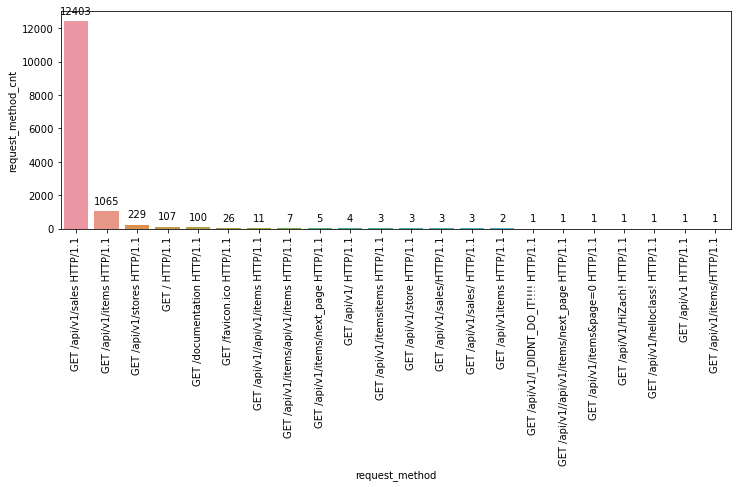

In [26]:
# plot the request_method_count for each request_method

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=request_method_df, x = 'request_method', y = 'request_method_cnt', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

#### Detecting anomalies by establishing a baseline and evaluate as new data arrives

Establish Baseline:

In [27]:
# baseline
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [28]:
train.head(3)

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472


In [29]:
train.size / df.size

0.9997138360280441

In [30]:
# Compute probabilities based on train sample:

request_method_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})

request_method_df.head()

,request_method,request_method_proba
0,GET /api/v1/sales HTTP/1.1,0.887577
1,GET /api/v1/items HTTP/1.1,0.076213
2,GET /api/v1/stores HTTP/1.1,0.016388
3,GET / HTTP/1.1,0.007657
4,GET /documentation HTTP/1.1,0.007156


In [31]:
request_method_df.shape

(20, 2)

In [32]:
df.shape

(13978, 6)

In [33]:
# Merge probabilities with all data (train + new data):

# Where the IP address is new, i.e. not seen in the training
# dataset, fill the probability wit a value of 0.

df = df.reset_index().merge(request_method_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.tail(5)

,ip,request_method,status,destination,request_agent,size_mb,request_method_proba
timestamp,,,,,,,
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486532,0.887577
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,0,python-requests/2.21.0,1.961066,0.000000
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.000000


#### Conditional Probabilities: Probabilities using 2 discrete variables

Probability of Status given IP Address:

In [34]:
# Conditional probability. Probability of A given B

# prob (A/B) = prob(A&B) / prob(B)

In [35]:
Pb = train.groupby('request_method').size().div(len(train))
Pab = train.groupby(['request_method', 'status']).\
                               size().div(len(train))

Pab.div(Pb, axis = 0, level = 'request_method' )

request_method                                status
GET / HTTP/1.1                                200       1.000000
GET /api/V1/HiZach! HTTP/1.1                  200       1.000000
GET /api/v1 HTTP/1.1                          200       1.000000
GET /api/v1/ HTTP/1.1                         200       1.000000
GET /api/v1//api/v1/items HTTP/1.1            200       1.000000
GET /api/v1//api/v1/items/next_page HTTP/1.1  200       1.000000
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        200       1.000000
GET /api/v1/helloclass! HTTP/1.1              200       1.000000
GET /api/v1/items HTTP/1.1                    200       0.996244
                                              499       0.003756
GET /api/v1/items&page=0 HTTP/1.1             200       1.000000
GET /api/v1/items/api/v1/items HTTP/1.1       200       1.000000
GET /api/v1/items/next_page HTTP/1.1          200       1.000000
GET /api/v1/itemsitems HTTP/1.1               200       1.000000
GET /api/v1/sales HTTP/1.1           

In [36]:
# calculate prob for each ip in train (Same as Pb above)

request_method_probs = train.groupby('request_method').size().div(len(train))

request_method_probs

request_method
GET / HTTP/1.1                                  0.007657
GET /api/V1/HiZach! HTTP/1.1                    0.000072
GET /api/v1 HTTP/1.1                            0.000072
GET /api/v1/ HTTP/1.1                           0.000286
GET /api/v1//api/v1/items HTTP/1.1              0.000787
GET /api/v1//api/v1/items/next_page HTTP/1.1    0.000072
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1          0.000072
GET /api/v1/helloclass! HTTP/1.1                0.000072
GET /api/v1/items HTTP/1.1                      0.076213
GET /api/v1/items&page=0 HTTP/1.1               0.000072
GET /api/v1/items/api/v1/items HTTP/1.1         0.000501
GET /api/v1/items/next_page HTTP/1.1            0.000358
GET /api/v1/itemsitems HTTP/1.1                 0.000215
GET /api/v1/sales HTTP/1.1                      0.887577
GET /api/v1/sales/ HTTP/1.1                     0.000215
GET /api/v1/store HTTP/1.1                      0.000215
GET /api/v1/stores HTTP/1.1                     0.016388
GET /api/v1items

In [38]:
# Conditional probability. Given a request_method, what is prob of a particular status
status_given_request_method = pd.DataFrame(train.groupby(['request_method', 'status']).\
                               size().div(len(train)).\
                               div(request_method_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(columns={0: 'proba_status_given_request_method'})
                              )

status_given_request_method

,request_method,status,proba_status_given_request_method
0,GET / HTTP/1.1,200,1.000000
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000
2,GET /api/v1 HTTP/1.1,200,1.000000
3,GET /api/v1/ HTTP/1.1,200,1.000000
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000
8,GET /api/v1/items HTTP/1.1,200,0.996244
9,GET /api/v1/items HTTP/1.1,499,0.003756


In [39]:
# calculate count for each combination of request_method and status
request_method_status_count = pd.DataFrame(train.groupby(['request_method', 'status'])['ip'].\
                              count().reset_index().\
                              rename(columns={'ip': 'request_method_status_count'}))

# merge request_method_status_count with status_given_request_method dataframe

request_method_status = status_given_request_method.merge(request_method_status_count)

In [40]:
request_method_status

,request_method,status,proba_status_given_request_method,request_method_status_count
0,GET / HTTP/1.1,200,1.000000,107
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000,1
2,GET /api/v1 HTTP/1.1,200,1.000000,1
3,GET /api/v1/ HTTP/1.1,200,1.000000,4
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000,11
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000,1
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000,1
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000,1
8,GET /api/v1/items HTTP/1.1,200,0.996244,1061
9,GET /api/v1/items HTTP/1.1,499,0.003756,4


##### Add these probabilities to the original events to detect anomalous events:

In [41]:
df = df.reset_index().merge(request_method_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')

df.head()

,ip,request_method,status,destination,request_agent,size_mb,request_method_proba,proba_status_given_request_method,request_method_status_count
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,0.887577,0.999032,12391.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,0.887577,0.999032,12391.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,0.887577,0.999032,12391.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,0.887577,0.999032,12391.0


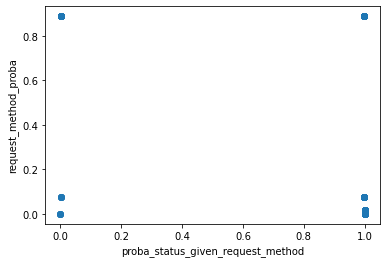

In [42]:
# plot the probabilities

plt.scatter(df.proba_status_given_request_method, df.request_method_proba)
plt.xlabel('proba_status_given_request_method')
plt.ylabel('request_method_proba');

In [43]:
df[(df['proba_status_given_request_method'] > 0.8) & (df['request_method_proba'] < 0.2)]

,ip,request_method,status,destination,request_agent,size_mb,request_method_proba,proba_status_given_request_method,request_method_status_count
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,0,python-requests/2.21.0,0.001266,0.016388,1.000000,229.0
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,0,python-requests/2.21.0,0.000040,0.007657,1.000000,107.0
2019-04-16 19:34:53,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:53,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003489,0.076213,0.996244,1061.0
...,...,...,...,...,...,...,...,...,...
2019-04-17 06:15:05,24.26.242.9,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-17 06:15:06,24.26.242.9,GET /api/v1/stores HTTP/1.1,200,0,python-requests/2.21.0,0.001266,0.016388,1.000000,229.0
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0


In [ ]:
### Takeaways:


